# Libraries

Notebook Color Scheme:


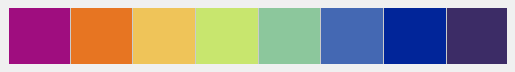

In [258]:
import warnings 
warnings.filterwarnings('ignore')

import pandas as pd 
import numpy as np 
import os 

# statistical methods 
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt 
import matplotlib.patches as patches
import seaborn as sns 

import time 
from datetime import datetime

color_pal = ["#9F0D7F", "#E77522", "#EFC459", "#C8E66E", "#8CC79C", "#4468B3", 
             "#012599", "#3C2C66"]

plt.style.use('fivethirtyeight')

plt.rcParams.update({'font.size': 16})

# Custom colors
class clr:
    S = '\033[1m' + '\033[90m'
    E = '\033[0m'
    
print(clr.S+"Notebook Color Scheme:"+clr.E)
sns.palplot(sns.color_palette(color_pal))
plt.show()

# Helper function

In [52]:
def create_features(df):
    
    """
    Create time series features based on time series index.
    
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.day_of_year
    
    return df

# Load data 

In [208]:
lp = pd.read_csv('data/raw/LP_AT0080000870000000000000000097058_2019.csv', 
                 sep=';', decimal=',', dayfirst=True, header=None, parse_dates=[0],
                 skiprows=7, names=['date','consumption_kwh'])

In [209]:
lp.head()

,date,consumption_kwh
0,01.01.2019 00:15,1.30
1,01.01.2019 00:30,0.77
2,01.01.2019 00:45,0.80
3,01.01.2019 01:00,0.78
4,01.01.2019 01:15,0.78


In [210]:
lp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             35040 non-null  object 
 1   consumption_kwh  35040 non-null  float64
dtypes: float64(1), object(1)
memory usage: 547.6+ KB


### Fix and load date as needed 

In [211]:
lp['date_new'] = pd.to_datetime(lp['date'], dayfirst=True, errors='coerce')

In [212]:
lp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             35040 non-null  object        
 1   consumption_kwh  35040 non-null  float64       
 2   date_new         35032 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 821.4+ KB


 Those in cell below is an overview about the date points that is not being recognized

 > after searching over it, the reasonable explanation for it was that the letters “A” and “B” in the date column of your data likely refer to the two hours that occur during the transition from daylight saving time to standard time. 
 
 >During this transition, the clocks are set back by one hour, so the hour that would normally be labeled as “2:00” occurs twice. To distinguish between these two hours, the first occurrence is often labeled as “2A” and the second occurrence is labeled as “2B”.
 

In [213]:
lp[lp.date_new.isnull()]

,date,consumption_kwh,date_new
28707,27.10.2019 2A:00,0.51,NaT
28708,27.10.2019 2A:15,0.57,NaT
28709,27.10.2019 2A:30,0.53,NaT
28710,27.10.2019 2A:45,0.50,NaT
28711,27.10.2019 2B:00,0.47,NaT
28712,27.10.2019 2B:15,0.53,NaT
28713,27.10.2019 2B:30,0.54,NaT
28714,27.10.2019 2B:45,0.50,NaT


 There is a couple of date (8) that is not being recognized properly 

In [214]:
lp.drop('date', axis =1, inplace=True)

In [215]:
lp.set_index('date_new', inplace=True)

In [217]:
lp.index.rename('date', inplace=True)

In [218]:
lp.head()

,consumption_kwh
date,
2019-01-01 00:15:00,1.30
2019-01-01 00:30:00,0.77
2019-01-01 00:45:00,0.80
2019-01-01 01:00:00,0.78
2019-01-01 01:15:00,0.78


> get conumption in KW rather than Kwh 

In [220]:
lp['consumption_kw'] = lp['consumption_kwh'] / 0.25


In [221]:
lp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35040 entries, 2019-01-01 00:15:00 to 2020-01-01 00:00:00
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   consumption_kwh  35040 non-null  float64
 1   consumption_kw   35040 non-null  float64
dtypes: float64(2)
memory usage: 821.2 KB


In [222]:
lp.index.dtype

dtype('<M8[ns]')

In [223]:
lp.head()

,consumption_kwh,consumption_kw
date,,
2019-01-01 00:15:00,1.30,5.20
2019-01-01 00:30:00,0.77,3.08
2019-01-01 00:45:00,0.80,3.20
2019-01-01 01:00:00,0.78,3.12
2019-01-01 01:15:00,0.78,3.12


In [224]:
lp.describe()

,consumption_kwh,consumption_kw
count,35040.000000,35040.000000
mean,1.448146,5.792586
std,0.864710,3.458839
min,0.270000,1.080000
25%,0.720000,2.880000
50%,1.190000,4.760000
75%,2.060000,8.240000
max,5.480000,21.920000


> save data 

In [225]:
ls

Data_analysis_tasks_with_python.pdf  data/                          plots/
README.md                            electricity_consumption.ipynb


In [226]:
lp.reset_index().to_csv('data/preprocessed/lp.csv', index=False)

keep consumption in kw and drop the kwh column 

In [227]:
lp.drop('consumption_kwh', axis=1, inplace=True)

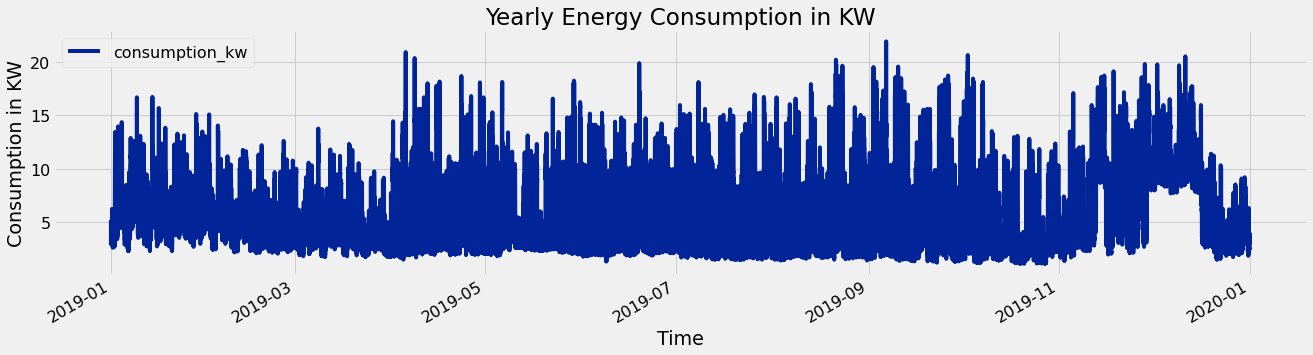

In [228]:
lp.plot(kind='line', 
        figsize=(20,5), 
        color=color_pal[6], 
        title='Yearly Energy Consumption in KW')

plt.xlabel('Time')
plt.ylabel('Consumption in KW')

plt.savefig('plots/lp/yearly_energy_consumption.png')

plt.show()

In [229]:
lp.index.min(), lp.index.max()

(Timestamp('2019-01-01 00:15:00'), Timestamp('2020-01-01 00:00:00'))

### make our date as 15 min interval 

In [230]:
lp= lp.resample('15T').mean()

### plot one day energy consumption


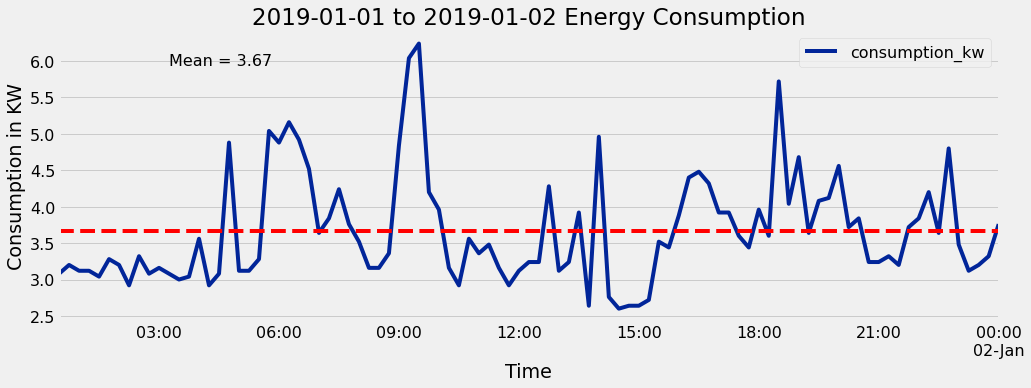

In [253]:
data = lp.loc[(lp.index > '2019-01-01 00:15:00') & (lp.index < '2019-01-02 00:15:00')]

data.plot(figsize=(15,5), title='2019-01-01 to 2019-01-02 Energy Consumption', color=color_pal[6])

mean_value = data['consumption_kw'].mean()

plt.axhline(y=mean_value, linestyle='--', color='red')

plt.text(x='2019-01-01 03:15:00', y =6, s=f'Mean = {mean_value:.2f}', ha='left', va='center')


plt.xlabel('Time')
plt.ylabel('Consumption in KW')

plt.savefig('plots/lp/one_day_energy_consumption.png')

plt.show()


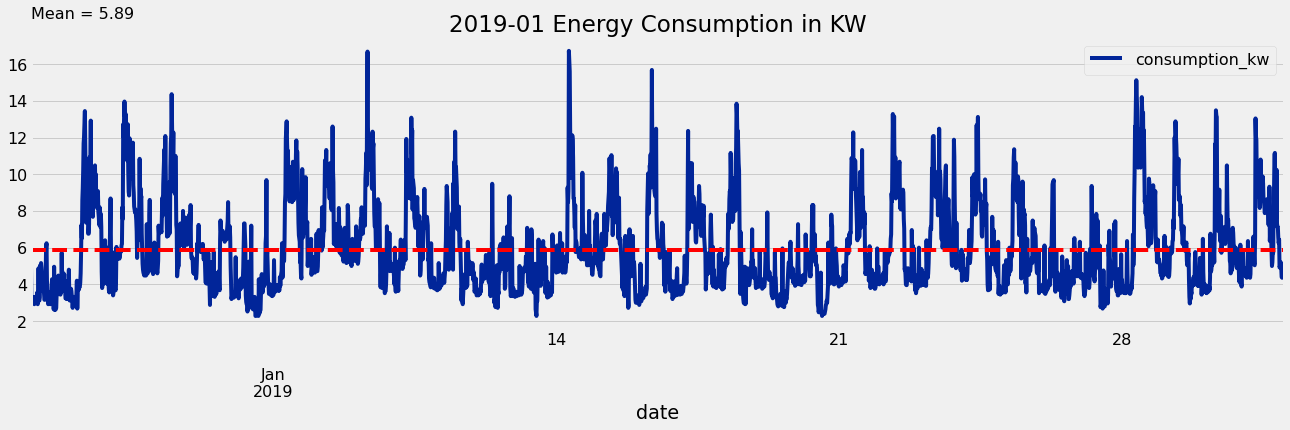

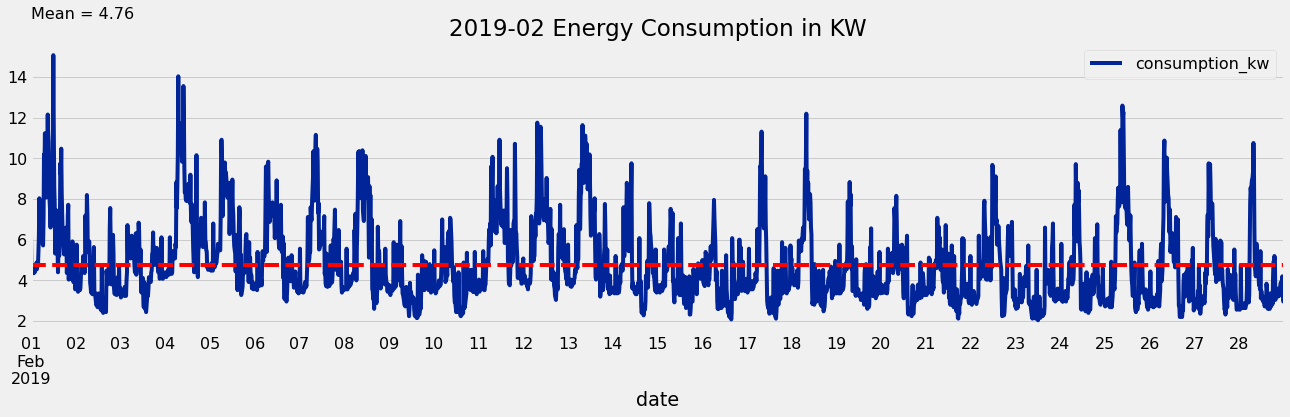

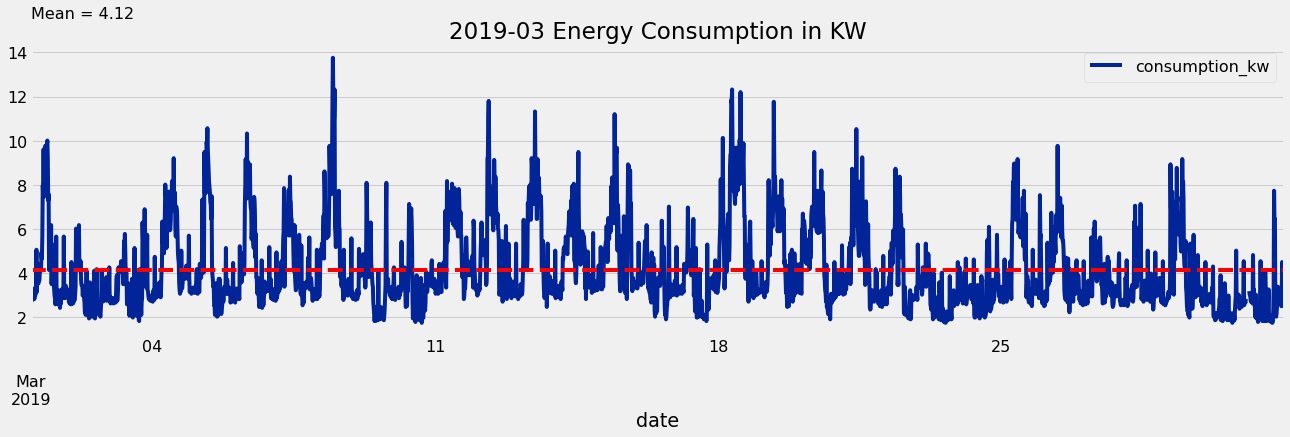

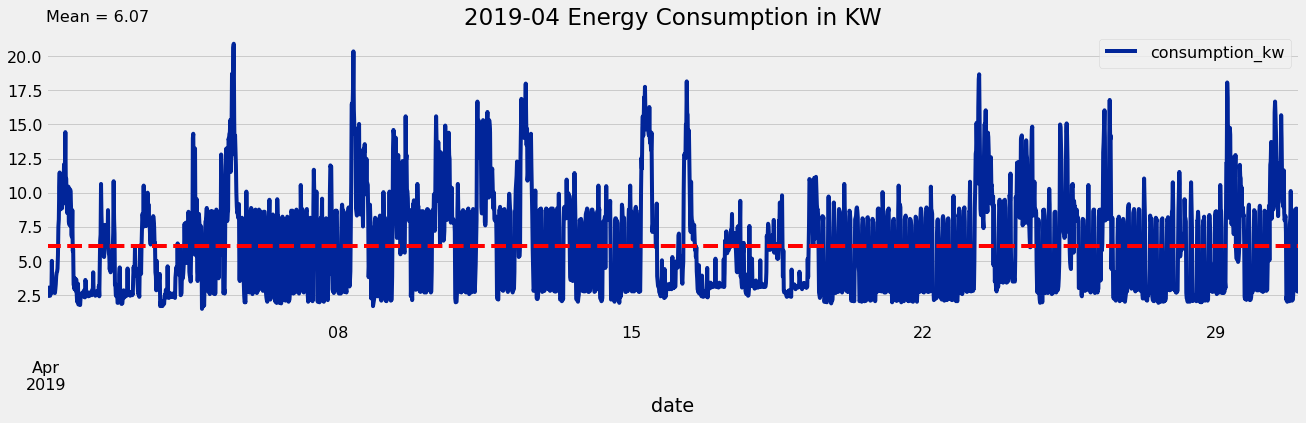

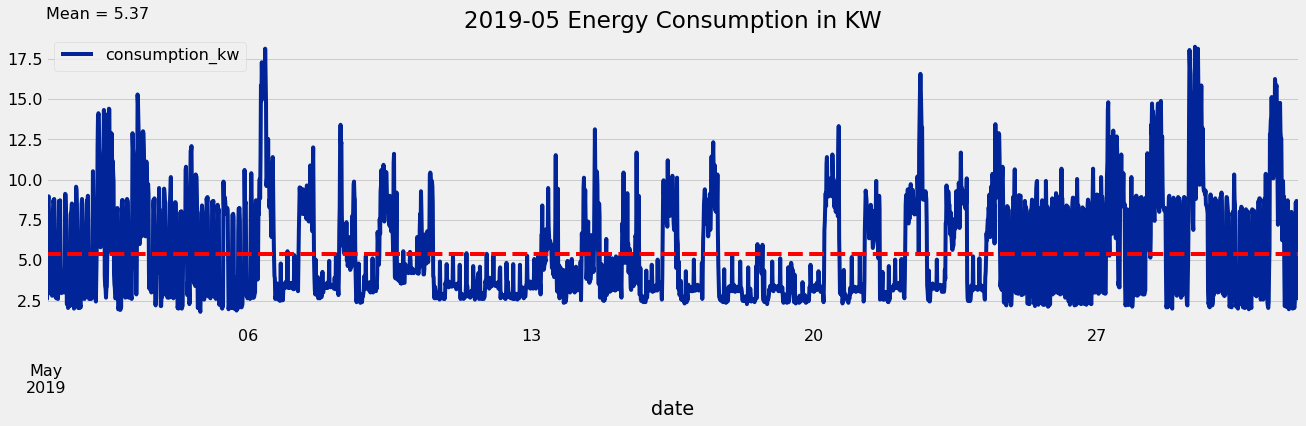

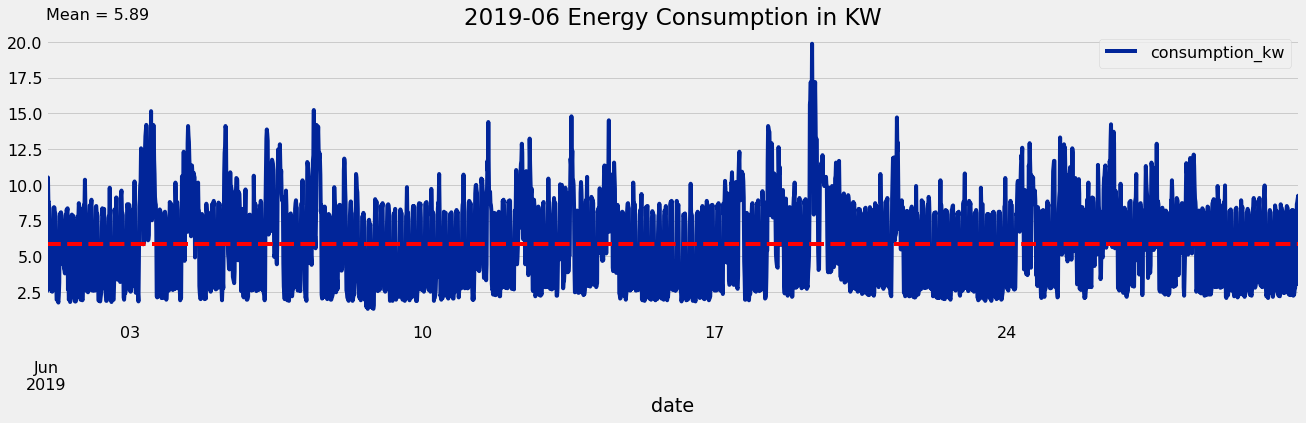

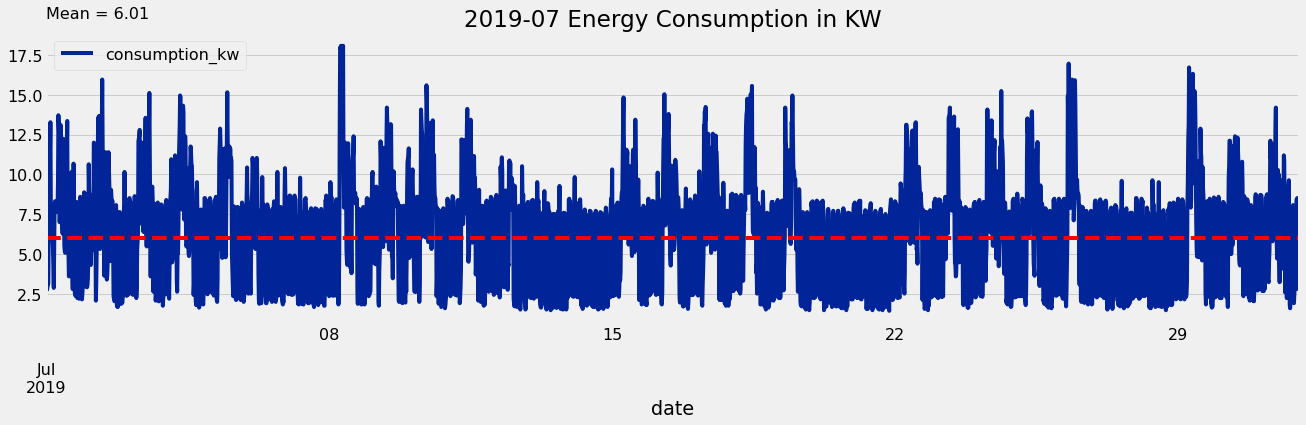

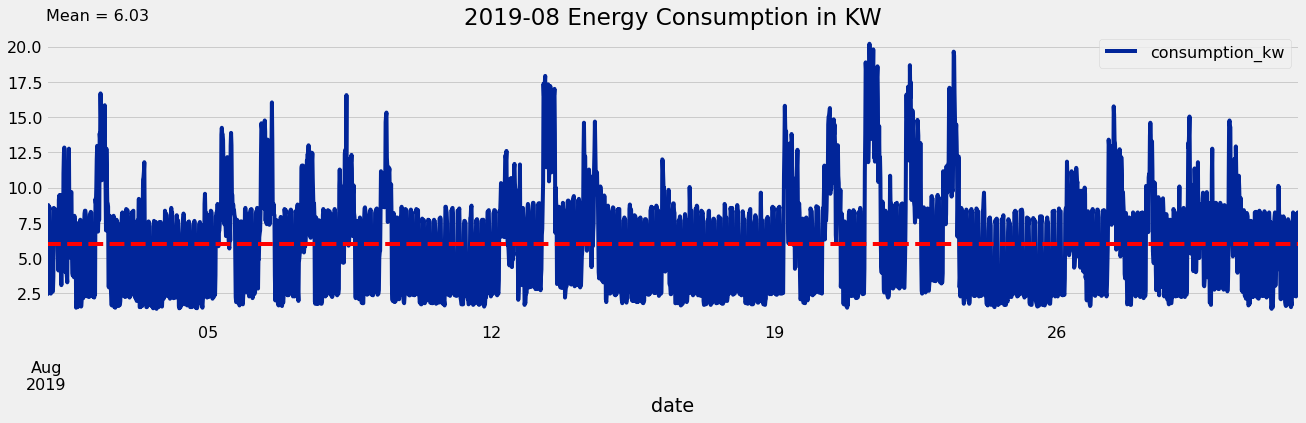

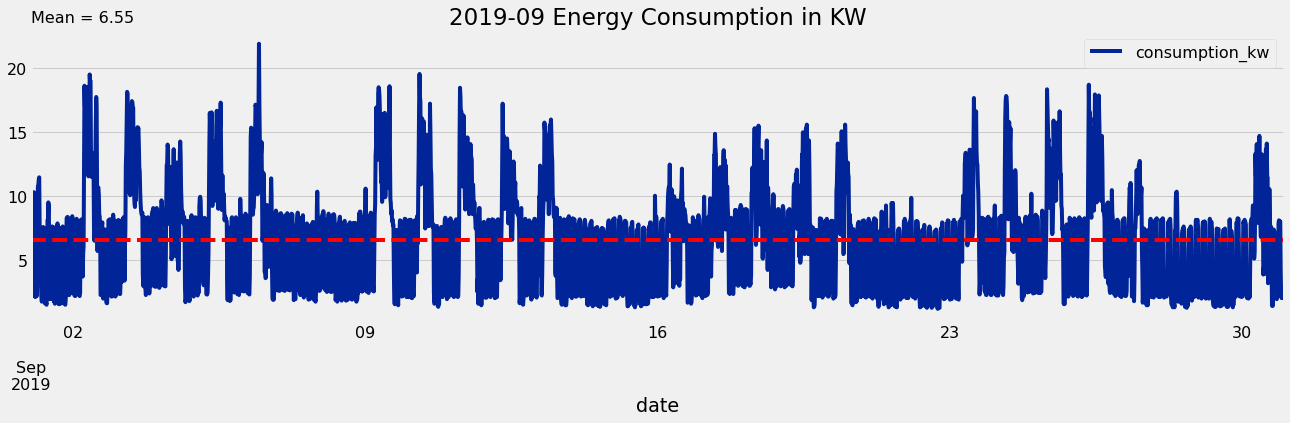

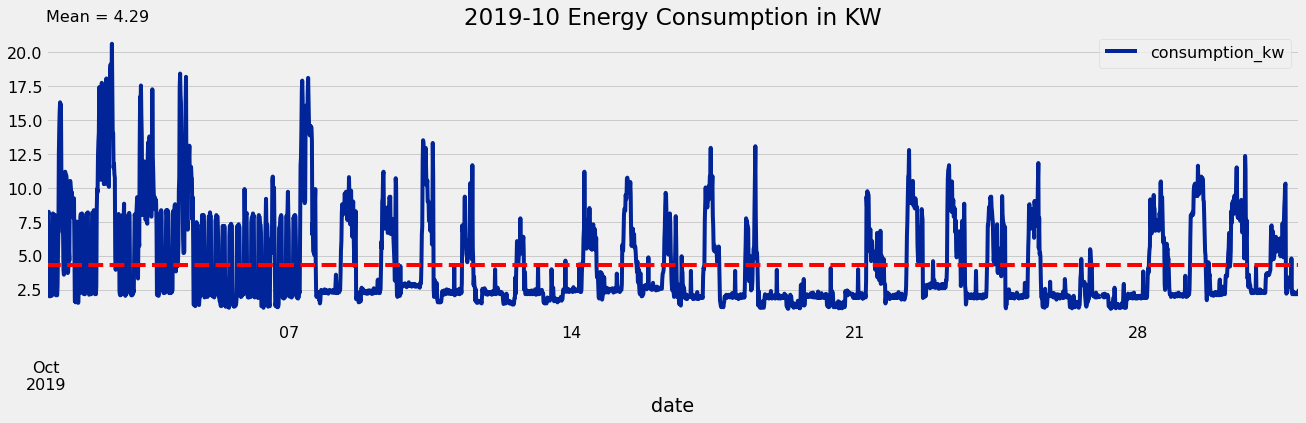

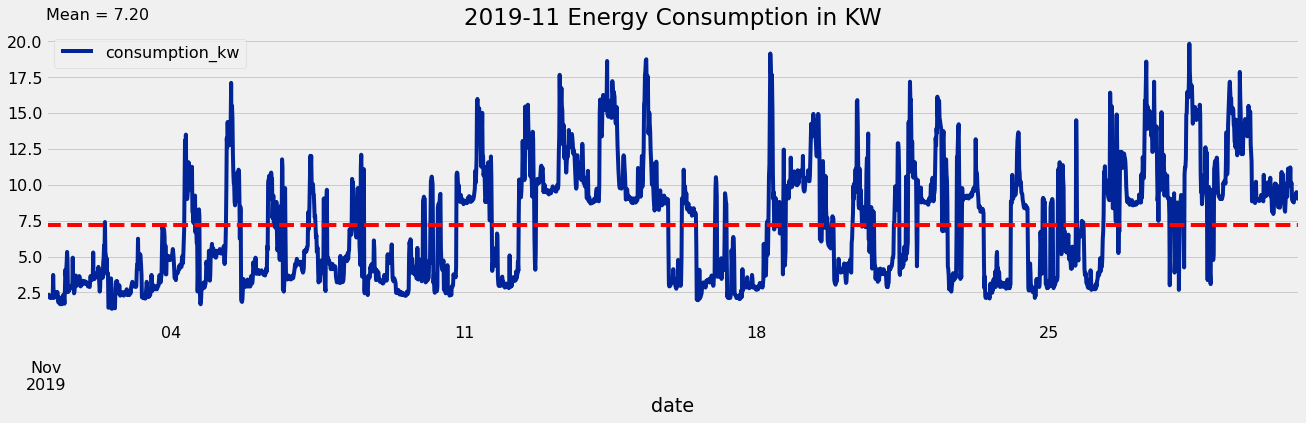

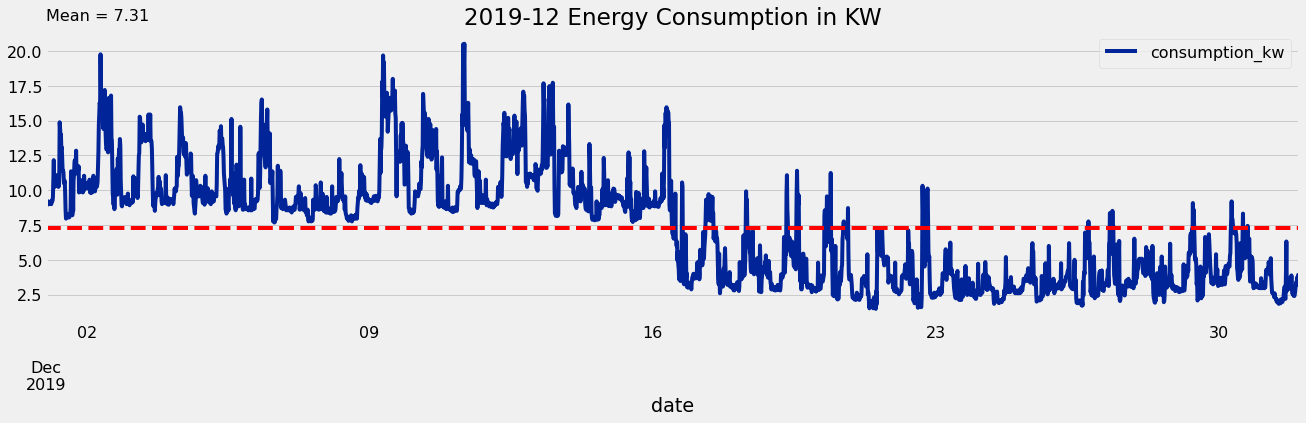

In [257]:
for month in range(1, 13):
    
    start_date = f'2019-{month:02d}-01 00:00:00'
    end_date = f'2019-{month + 1:02d}-01 00:00:00' if month != 12 else f'{2019 + 1}-01-01 00:00:00'
    
    data = lp.loc[(lp.index >= start_date) & (lp.index < end_date)]
    mean_value = data['consumption_kw'].mean()
    data.plot(figsize=(20,5), title=f'2019-{month:02d} Energy Consumption in KW', color=color_pal[6])
    plt.axhline(y=mean_value, linestyle='--', color='red')
    plt.text(x=start_date, y=data.consumption_kw.max()+2, s=f'Mean = {mean_value:.2f}', ha='left', va='center')
    
    filename = f'plots/lp/2019-{month:02d}_energy_consumption.png'
    
    plt.savefig(filename)


## Time series decomposition 

> Time series decomposition is a statisitcal technique that separates a time series into distinct components, each of them represent a pattern category, which can help to understand the data and make more accurate forecasts.

> We may have different combinations of trends and seasonality. Depending on the nature of the trends and seasonality, time series can be modeled as an additive or multiplicative time series. Each observation in the series can be expressed as either a sum or product of the component. 

* Additive time series 
value = base_level + trend + seasonality + error

* multiplicative time series 
value = base_level * trend * seasonality * error

> the chice between the two methods depends on if the <b>seasonal variation is relatively constant over time</b>, an additive decomposition is your choice. if the <b>seasonal variation increases over time</b>, a multiplicative decomposition may be more appropriate. 


The period part is a crucial part given our focus on dialy or weekly seasonals. 

* daily === period=96 (15 * 24)

* weekly === period=672 (7 * 24 * 4)

In [262]:
lp.dropna(inplace=True)

In [269]:
multi_decomposition = seasonal_decompose(lp['consumption_kw'],
                                         model='multiplicative',
                                         period=672)

additive_decomposition = seasonal_decompose(lp['consumption_kw'],
                                            model='additive',
                                            period=672)

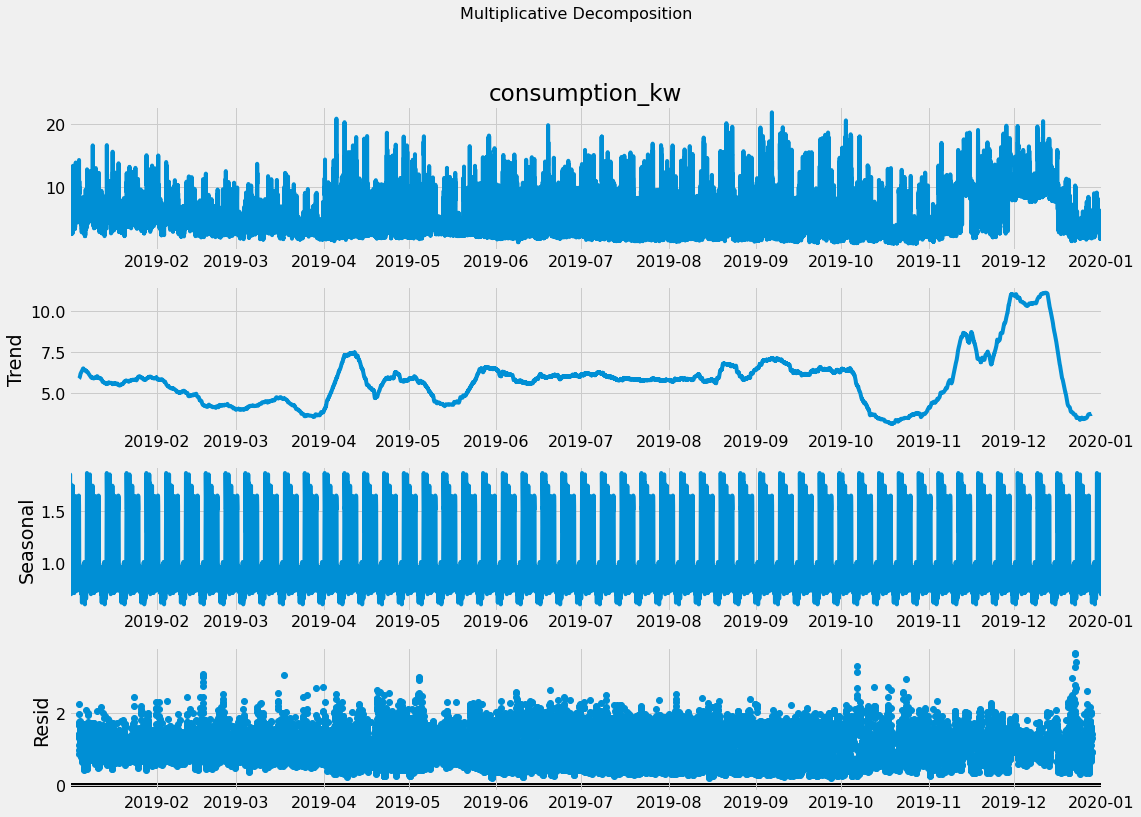

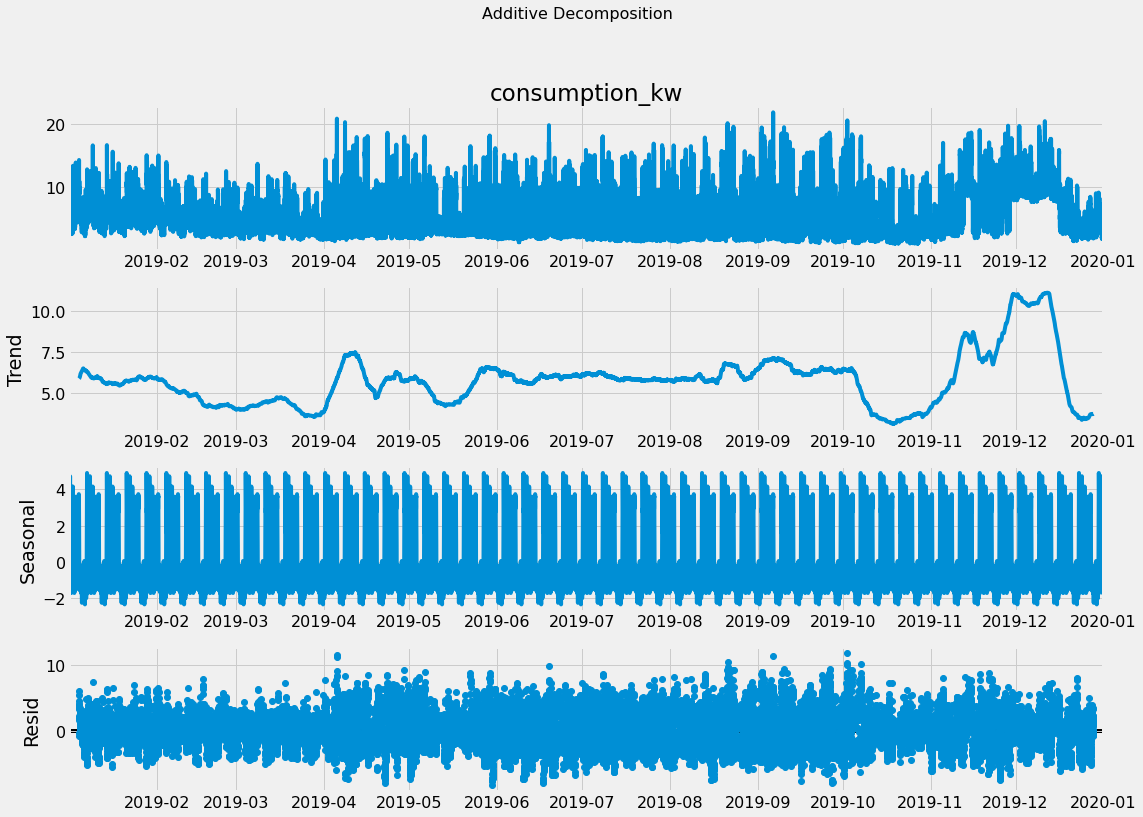

In [270]:
plt.rcParams.update({'figure.figsize': (16,12)})

multi_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

## extract time features to further analysis

In [126]:
lp = create_features(lp)

## monthly energy consumption 

Text(0.5, 1.0, 'Kwh by month')

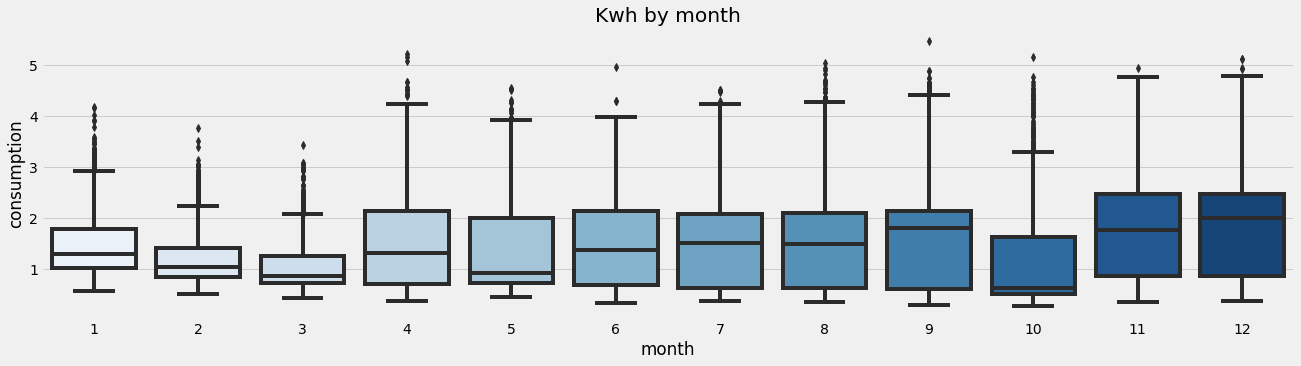

In [129]:
fig, ax = plt.subplots(figsize=(20, 5))

sns.boxplot(data=lp, x = 'month', y = 'consumption', palette='Blues')

ax.set_title("Kwh by month")

Text(0.5, 1.0, 'Kwh by month')

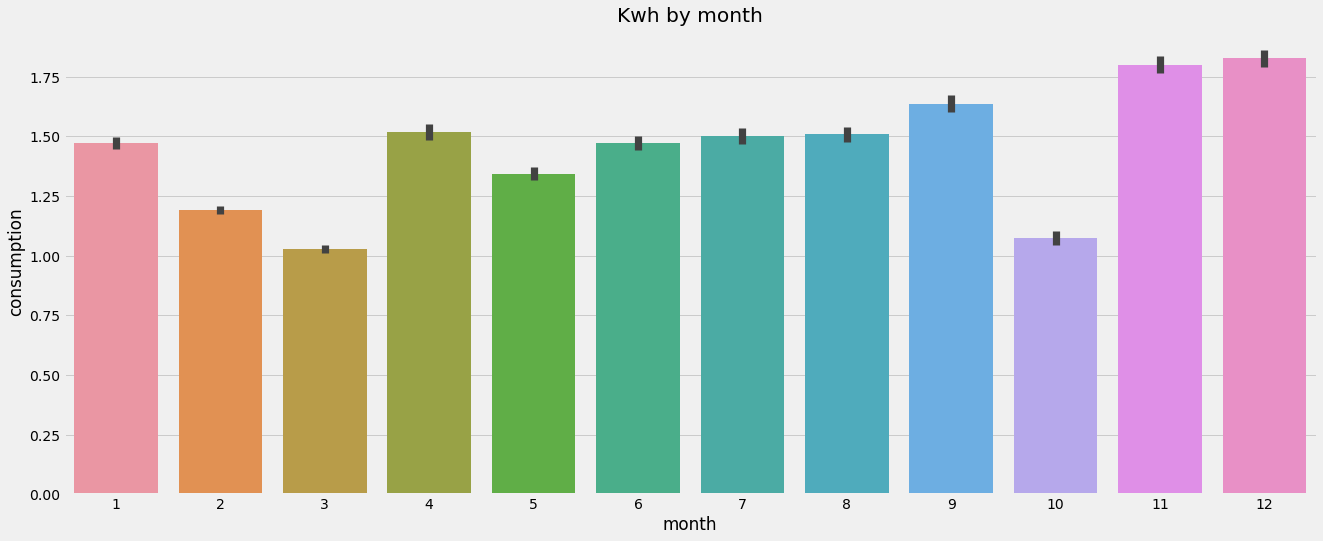

In [130]:
fig, ax = plt.subplots(figsize=(20, 8))

sns.barplot(data=lp, x = 'month', y = 'consumption')

ax.set_title("Kwh by month")

### compute monthly energy consumption 

In [64]:
# resample the data on a monthly basis
monthly_data = lp['consumption'].resample('M').sum()

In [65]:
monthly_data15

date
2019-01-31    4382.95
2019-02-28    3200.22
2019-03-31    3060.45
2019-04-30    4366.96
2019-05-31    3995.46
2019-06-30    4241.41
2019-07-31    4473.50
2019-08-31    4487.53
2019-09-30    4714.68
2019-10-31    3186.33
2019-11-30    5186.26
2019-12-31    5442.35
2020-01-31       0.80
Freq: M, Name: consumption, dtype: float64

In [ ]:
# create a figure and axes
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True)

# loop through each month and plot the data
for i in range(3):
    axs[i].plot(monthly_data[i])
    axs[i].set_title(monthly_data.index[i].strftime('%B'))

plt.show()